# Solving Frozen Lake Problem Using Policy-Based Methods

Modified from: https://github.com/PacktPublishing/Hands-On-Reinforcement-Learning-with-Python/tree/master/Chapter03

## Goal:

Imagine, there is a frozen lake from your home to office, you should walk on the frozen lake
to reach your office. But oops! there will be a hole in the frozen lake in between, so you have
to be careful while walking in the frozen lake to avoid getting trapped at holes.
Look at the below figure where, 

1. S is the starting position (Home)
2. F is the Frozen lake where you can walk
3. H is the Hole which you have to be so careful about
4. G is the Goal (office)


![title](https://gymnasium.farama.org/_images/frozen_lake.gif)

Okay, now let us use our agent instead of you to find the correct way to reach the office.
The agent goal is to find the optimal path to reach from S to G without getting trapped at H.
How an agent can achieve this? We give +1 point as a reward to the agent if it correctly
walks on the frozen lake and 0 points if it falls into the hole. So that agent could determine
which is the right action. An agent will now try to find the optimal policy. Optimal policy
implies taking the correct path which maximizes the agent reward. If the agent is
maximizing the reward, apparently agent is learning to skip the hole and reach the
destination.

 First, we import necessary libraries

In [10]:
import gymnasium as gym
from gymnasium.envs.toy_text.frozen_lake import generate_random_map
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Policy-Based Methods 

 

## Overview
Policy optimization alternates between two steps:
1. Policy Evaluation: Compute the value of the current policy
2. Policy Improvement: Update the policy based on the computed values

## Mathematical Formulation

### (a) Policy Evaluation
For a fixed policy π, compute $Q^{\pi}$ by solving the linear system:

$Q^{\pi}(s,a) = \sum_{s'} P(s'|s,a)[R(s,a,s') + \gamma \sum_{a'} \pi(a'|s')Q^{\pi}(s',a')]$

This can be solved using iterative methods similar to value iteration.

### (b) Policy Improvement
Update the policy using the computed $Q^{\pi}$ values. 

For example, policy iteration adopts: 

$\pi_{new}(a|s) = \begin{cases} 1 & \text{if } a = \arg\max_a Q^{\pi}(s,a) \\ 0 & \text{otherwise} \end{cases}$

### Advantage Function
The advantage function Aπ measures how much better an action is compared to the policy's average:

$A^{\pi}(s,a) = Q^{\pi}(s,a) - V^{\pi}(s)$

where $V^{\pi}(s) = \sum_a \pi(a|s)Q^{\pi}(s,a)$
Both the advantage function and $Q^{\pi}$ can be used as descent directions for policy optimization. 


 
### Policy Optimization Stopping Criteria Using Advantage Function

#### Theoretical Basis

1. **Optimal Policy Property**:
   - For an optimal policy π*, we have:$A^{\pi} (s,a) \leq  0$ for all (s,a)
   - This means no action can be better than what the policy currently suggests

2. **Policy Improvement Theorem**:
   - If $A^{\pi} (s,a) > 0$, then improving the policy by increasing $\pi(a|s)$ will lead to better performance
   - If $ \max_aA^{\pi} (s,a) \approx 0$ for all s, then we're close to optimal



# Policy evaluation function

In [11]:
import numpy as np

def evaluate_policy(env, policy, gamma=0.99, threshold=1e-8):
    """
    Compute Qπ and Aπ for a given policy.
    
    Args:
        env: Gymnasium environment
        policy: Matrix of shape (n_states, n_actions) containing π(a|s)
        gamma: Discount factor
        threshold: Convergence threshold
    
    Returns:
        Q_pi: Q-values under policy π
        A_pi: Advantage values under policy π
    """
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    
    # Initialize Q-values
    Q_pi = np.zeros((n_states, n_actions))
    
    # Policy evaluation loop
    while True:
        Q_old = Q_pi.copy()
        
        # Update each state-action pair
        for s in range(n_states):
            for a in range(n_actions):
                # Calculate expected value under current policy
                expected_value = 0
                
                # Sum over all possible transitions
                for prob, next_state, reward, _ in env.unwrapped.P[s][a]:
                    # Calculate value of next state under policy
                    next_state_value = 0
                    for next_action in range(n_actions):
                        next_state_value += policy[next_state, next_action] * Q_old[next_state, next_action]
                    
                    # Add contribution of this transition
                    expected_value += prob * (reward + gamma * next_state_value)
                
                Q_pi[s, a] = expected_value
        
        # Check convergence
        if np.max(np.abs(Q_pi - Q_old)) < threshold:
            break
    
    # Compute V^π(s) = Σa π(a|s)Q^π(s,a)
    V_pi = np.sum(policy * Q_pi, axis=1)
    
    # Compute advantage function A^π(s,a) = Q^π(s,a) - V^π(s)
    A_pi = Q_pi - V_pi[:, np.newaxis]
    
    return Q_pi, A_pi


In [12]:
def check_policy_optimality(A_pi, threshold=1e-6):
    """
    Check if a policy is optimal using the advantage function.
    
    Args:
        A_pi: Advantage function matrix of shape (n_states, n_actions)
        threshold: Tolerance for considering an advantage value significant
    
    Returns:
        is_optimal: Boolean indicating if policy is optimal
        max_advantage: Maximum advantage value found
        problematic_states: List of states with significant positive advantages
    """
    # Get maximum advantage for each state
    max_advantages = np.max(A_pi, axis=1)
    
    # Find states where max advantage is significantly positive
    problematic_states = np.where(max_advantages > threshold)[0]
    
    # Policy is optimal if no state has significant positive advantage
    is_optimal = len(problematic_states) == 0
    max_advantage = np.max(max_advantages)
    
    return is_optimal, max_advantage, problematic_states

## Helper functions 

In [13]:
def print_state_info(env, state):
    """Print state information in different formats"""
    # Get grid dimensions
    n_rows = env.unwrapped.nrow
    n_cols = env.unwrapped.ncol
    
    # Convert state number to grid position
    row = state // n_cols
    col = state % n_cols
    
    print(f"State number: {state}")
    print(f"Grid position (row, col): ({row}, {col})")
    
    # Get the map
    desc = env.unwrapped.desc.copy()
    
    # Mark current position with 'P'
    desc = desc.tolist()
    old_char = desc[row][col]
    desc[row][col] = b'P'
    
    print("\nCurrent map (P marks current position, original tile was {}):\n".format(old_char.decode()))
    for row in desc:
        print("".join([c.decode('utf-8') for c in row]))

In [14]:

def plot_policy_grid(policy, desc, size=8):
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Draw grid
    for i in range(size+1):
        ax.axhline(i, color='black', linewidth=1)
        ax.axvline(i, color='black', linewidth=1)
    
    # Set up the plot
    ax.set_xticks([])
    ax.set_yticks([])
    ax.invert_yaxis()
    
    # Dictionary for arrow directions
    arrows = {0: '←', 1: '↓', 2: '→', 3: '↑'}
    colors = {'S': 'green', 'F': 'lightblue', 'H': 'red', 'G': 'gold'}
    
    # Fill cells and add arrows
    for i in range(size):
        for j in range(size):
            state = i * size + j
            cell_type = desc[i][j].decode('utf-8')
            
            # Fill cell color based on type
            rect = plt.Rectangle((j, i), 1, 1, facecolor=colors[cell_type], alpha=0.3)
            ax.add_patch(rect)
            
            # Add cell type
            ax.text(j+0.1, i+0.2, cell_type, fontsize=12)
            
            # Add arrow for policy (except in holes and goal)
            if cell_type not in ['H', 'G']:
                action = int(policy[state])
                ax.text(j+0.5, i+0.5, arrows[action], fontsize=20, ha='center', va='center')
    
    plt.title('Optimal Policy\n(S: Start, F: Frozen, H: Hole, G: Goal)\n(←: Left, →: Right, ↑: Up, ↓: Down)')
    plt.show()

    
def get_greedy_policy(policy, size=8):
    """
    Extract the most probable actions from a policy.
    
    Args:
        policy: Array of shape (n_states, n_actions)
        size: Grid size
    
    Returns:
        greedy_actions: Array of most probable actions for each state
    """
    # Get the most probable action for each state
    greedy_actions = np.argmax(policy, axis=1)
    
    # Print policy with probabilities
    print("\nMost probable actions and their probabilities:")
    for i in range(size):
        for j in range(size):
            state = i * size + j
            action = greedy_actions[state]
            prob = policy[state, action]
            print(f"[{action}:{prob:.2f}]", end=" ")
        print()
    
    # Print in the standard format
    print("\nOptimal Policy (0:LEFT, 1:DOWN, 2:RIGHT, 3:UP):")
    print(greedy_actions.reshape(size, size))
    
    return greedy_actions

In [15]:
import gymnasium as gym
from gymnasium.envs.toy_text.frozen_lake import generate_random_map
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec

def plot_trajectory_grid(trajectory, desc, size=8):
    """
    Plots the grid with the trajectory overlay.
    """
    # Create figure with GridSpec to make room for colorbar
    fig = plt.figure(figsize=(12, 10))
    gs = GridSpec(1, 20, figure=fig)
    ax = fig.add_subplot(gs[:, :-1])  # Main plot
    cax = fig.add_subplot(gs[:, -1])  # Colorbar axis
    
    # Draw grid
    for i in range(size+1):
        ax.axhline(i, color='black', linewidth=1)
        ax.axvline(i, color='black', linewidth=1)
    
    # Set up the plot
    ax.set_xticks([])
    ax.set_yticks([])
    ax.invert_yaxis()
    
    # Colors for different cell types
    colors = {'S': 'green', 'F': 'lightblue', 'H': 'red', 'G': 'gold'}
    
    # Create colormap for trajectory
    n_steps = len(trajectory)
    cmap = plt.cm.Reds
    
    # Fill cells and mark trajectory
    for i in range(size):
        for j in range(size):
            state = i * size + j
            cell_type = desc[i][j].decode('utf-8')
            
            # Fill cell color based on type
            rect = plt.Rectangle((j, i), 1, 1, facecolor=colors[cell_type], alpha=0.3)
            ax.add_patch(rect)
            
            # Add cell type
            ax.text(j+0.1, i+0.2, cell_type, fontsize=12)
            
            # Mark trajectory steps
            for step, traj_state in enumerate(trajectory):
                if state == traj_state:
                    color = cmap(float(step) / max(1, n_steps-1))
                    circle = plt.Circle((j+0.5, i+0.5), 0.3, color=color, alpha=0.6)
                    ax.add_patch(circle)
                    # Add step number
                    ax.text(j+0.5, i+0.5, str(step), ha='center', va='center', 
                           color='white', fontweight='bold', fontsize=8)
    
    # Add colorbar
    norm = plt.Normalize(0, n_steps-1)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    plt.colorbar(sm, cax=cax, label='Step number')
    
    # Print trajectory information
    ax.set_title('Policy Trajectory\n(S: Start, F: Frozen, H: Hole, G: Goal)\n'
                f'Steps: {n_steps}, States: {trajectory}')
    
    plt.tight_layout()
    plt.show()

def simulate_trajectory(env, policy, max_steps=400):
    """
    Simulates a trajectory using the given policy.
    """
    state, _ = env.reset()
    trajectory = [state]
    total_reward = 0
    
    for _ in range(max_steps):
        action = int(policy[state])
        next_state, reward, terminated, truncated, _ = env.step(action)
        total_reward += reward
        trajectory.append(next_state)
        
        if terminated or truncated:
            break
            
        state = next_state
    
    return trajectory, total_reward


def evaluate_policy_return(env, policy, n_trajectories=50, max_steps=400):
    """
    Evaluate policy by running multiple trajectories and computing average return.
    """
    returns = []
    
    for _ in range(n_trajectories):
        state, _ = env.reset()
        total_reward = 0
        
        for _ in range(max_steps):
            action = np.random.choice(len(policy[state]), p=policy[state])
            next_state, reward, done, truncated, _ = env.step(action)
            total_reward += reward
            
            if done or truncated:
                break
                
            state = next_state
            
        returns.append(total_reward)
    
    return np.mean(returns), np.std(returns)
    

# Policy iteration

In [16]:
def policy_iteration_with_returns(env, gamma=0.99, max_iterations=1000, eval_trajectories=100):
    """
    Policy iteration tracking only policy performance J(π).
    """
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    
    # Initialize policy uniformly
    policy = np.ones((n_states, n_actions)) / n_actions
    performance_history = []
    
    for iteration in range(max_iterations):
        # Evaluate current policy performance
        avg_return, std_return = evaluate_policy_return(env, policy, eval_trajectories)
        performance_history.append({
            'iteration': iteration,
            'average_return': avg_return,
            'std_return': std_return
        })
        
        print(f"Iteration {iteration}: J(π) = {avg_return:.4f} ± {std_return:.4f}")
        
        # Policy evaluation
        Q_pi, _ = evaluate_policy(env, policy, gamma)
        
        # Policy improvement
        new_policy = np.zeros_like(policy)
        best_actions = np.argmax(Q_pi, axis=1)
        new_policy[np.arange(n_states), best_actions] = 1.0
        
        # Check if policy has changed
        if np.allclose(policy, new_policy):
            print(f"Policy converged at iteration {iteration}")
            break
            
        policy = new_policy
    
    return policy, Q_pi, performance_history

def plot_policy_returns(performance_history):
    """
    Plot policy performance J(π) over iterations.
    """
    iterations = [stat['iteration'] for stat in performance_history]
    avg_returns = [stat['average_return'] for stat in performance_history]
    std_returns = [stat['std_return'] for stat in performance_history]
    
    plt.figure(figsize=(10, 6))
    plt.plot(iterations, avg_returns, 'b-', label='J(π)')
    plt.fill_between(iterations, 
                    [r - s for r, s in zip(avg_returns, std_returns)],
                    [r + s for r, s in zip(avg_returns, std_returns)],
                    color='b', alpha=0.2, label='±1 std')
    plt.xlabel('Iteration')
    plt.ylabel('Average Return J(π)')
    plt.title('Policy Performance over Iterations')
    plt.grid(True)
    plt.legend()
    plt.show()

Initial State:
State number: 0
Grid position (row, col): (0, 0)

Current map (P marks current position, original tile was S):

PFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

 Start policy iteration
Iteration 0: J(π) = 0.0000 ± 0.0000
Iteration 1: J(π) = 0.4200 ± 0.4936
Iteration 2: J(π) = 0.6800 ± 0.4665
Policy converged at iteration 2

Optimal Policy (0:LEFT, 1:DOWN, 2:RIGHT, 3:UP):

Most probable actions and their probabilities:
[3:1.00] [2:1.00] [2:1.00] [2:1.00] [2:1.00] [2:1.00] [2:1.00] [2:1.00] 
[3:1.00] [3:1.00] [3:1.00] [3:1.00] [3:1.00] [2:1.00] [2:1.00] [1:1.00] 
[3:1.00] [3:1.00] [0:1.00] [0:1.00] [2:1.00] [3:1.00] [2:1.00] [1:1.00] 
[3:1.00] [3:1.00] [3:1.00] [1:1.00] [0:1.00] [0:1.00] [2:1.00] [2:1.00] 
[0:1.00] [3:1.00] [0:1.00] [0:1.00] [2:1.00] [1:1.00] [3:1.00] [2:1.00] 
[0:1.00] [0:1.00] [0:1.00] [1:1.00] [3:1.00] [0:1.00] [0:1.00] [2:1.00] 
[0:1.00] [0:1.00] [1:1.00] [0:1.00] [0:1.00] [0:1.00] [0:1.00] [2:1.00] 
[0:1.00] [1:1.00] [0:1.00] [

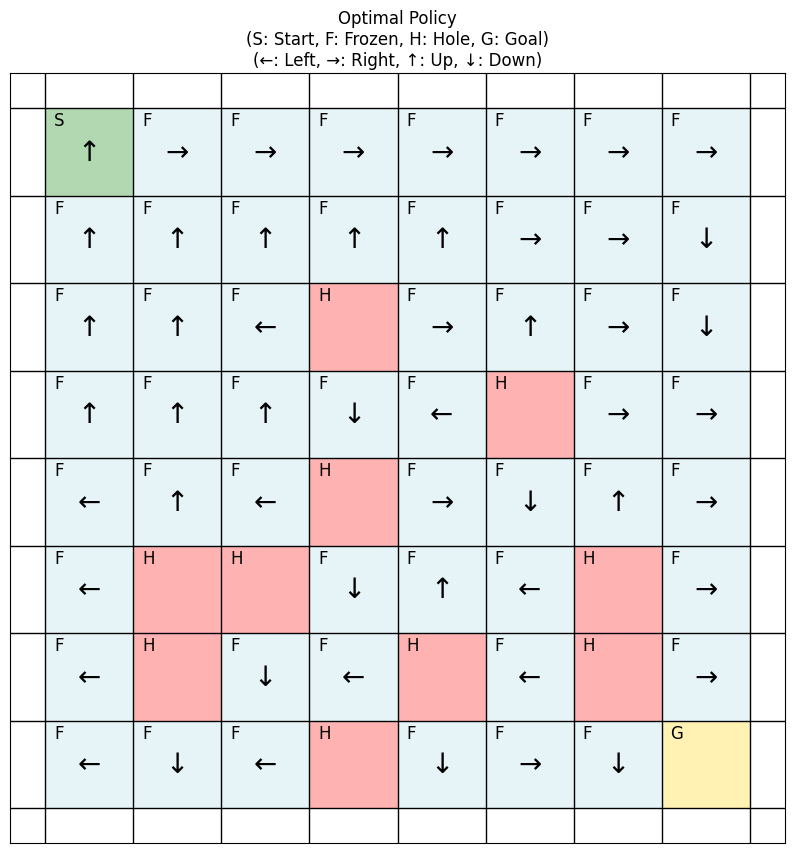

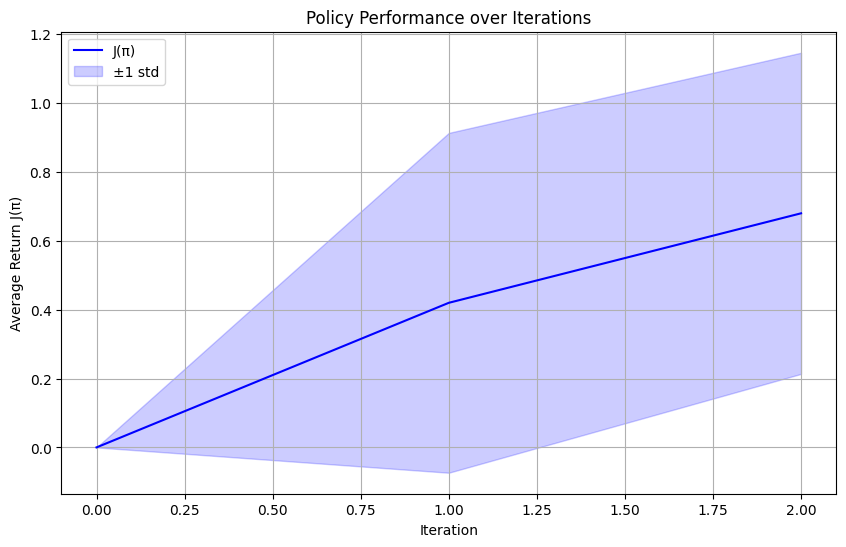

In [17]:
size = 8
env = gym.make('FrozenLake-v1',  desc=None, map_name="8x8", is_slippery=True)

# Reset environment and get initial state
initial_state, _ = env.reset()

# Print state information
print("Initial State:")
print_state_info(env, initial_state)

print("\n Start policy iteration")
    
# Run policy iteration
final_policy, Q_values, history = policy_iteration_with_returns(env)

print("\nOptimal Policy (0:LEFT, 1:DOWN, 2:RIGHT, 3:UP):")
pi_greedy_policy = get_greedy_policy(final_policy)

# Visualize the policy
plot_policy_grid(pi_greedy_policy, env.unwrapped.desc)

# Plot returns
plot_policy_returns(history)

env.close()

# Projected Gradient Descent and Frank-Wolfe



 

## Projected Gradient Descent (PGD)
1. Gradient step:
   - $\tilde{\pi}(\cdot|s) = \pi(\cdot|s) + \alpha\nabla J(\pi)(s,\cdot)$
   - $\nabla J(\pi)(s,a) = Q^\pi(s,a)$ (policy gradient theorem)

2. Projection onto probability simplex:
   - Given $y$, find $x^* = \arg\min_{x\in\Delta} \|x - y\|^2$
   - Where $\Delta = \{x \in \mathbb{R}^n : x \geq 0, \sum_i x_i = 1\}$

## Frank-Wolfe Algorithm
1. Linear optimization over simplex:
   - $s(\pi) = \arg\max_{x\in\Delta} \langle x, \nabla J(\pi)\rangle$
   - Solution: $x$ puts all mass on maximum component
   - $s(\pi)(\cdot|s) = e_k$ where $k = \arg\max_a Q^\pi(s,a)$

2. Update:
   - $\pi_{\text{new}}(\cdot|s) = (1-\eta)\pi(\cdot|s) + \eta s(\pi)(\cdot|s)$
   - Step size $\eta = \frac{2}{t+2}$ or by line search

Where:
- $\Delta$ is the probability simplex
- $e_k$ is the standard basis vector (1 at position k, 0 elsewhere)
- $t$ is the iteration number
- $\alpha$ is the learning rate for PGD
- $Q^\pi$ is the state-action value function under policy $\pi$



In [18]:
import numpy as np
import matplotlib.pyplot as plt

def project_simplex(y):
    """
    Project vector y onto probability simplex.
    """
    n = len(y)
    sorted_y = np.sort(y)[::-1]  # descending order
    cumsum = np.cumsum(sorted_y)
    
    for k in range(n-1, -1, -1):
        tau = (cumsum[k] - 1.0) / (k + 1)
        if tau <= sorted_y[k]:
            break
    
    return np.maximum(y - tau, 0.0)

 

In [19]:
def check_advantage_convergence(A_pi, threshold=1e-4):
    """
    Check convergence using advantage function.
    Policy is near-optimal if max advantage is close to 0.
    
    Args:
        A_pi: Advantage function matrix of shape (n_states, n_actions)
        threshold: Convergence threshold
    
    Returns:
        converged: Boolean indicating if policy has converged
        max_advantage: Maximum advantage value
    """
    max_advantage = np.max(A_pi)
    converged = max_advantage < threshold
    return converged, max_advantage

def policy_gradient_descent(env, n_iterations=500, alpha=0.2, gamma=0.99, threshold=1e-4, print_freq = 50):
    """
    Projected gradient descent for policy optimization with advantage-based stopping.
    """
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    
    # Initialize random policy
    policy = np.random.uniform(size=(n_states, n_actions))
    policy = policy / policy.sum(axis=1, keepdims=True)
    
    # Track performance
    performance_history = []
    advantage_history = []
    
    for t in range(n_iterations):
        # Evaluate current policy
        avg_return, std_return = evaluate_policy_return(env, policy)
        performance_history.append((avg_return, std_return))
        
        # Compute Q^π and A^π
        Q_pi, A_pi = evaluate_policy(env, policy, gamma)
        
        # Check convergence
        converged, max_advantage = check_advantage_convergence(A_pi, threshold)
        advantage_history.append(max_advantage)

        if t% print_freq == 0:
            print(f"Iteration {t}: J(π) = {avg_return:.4f} ± {std_return:.4f}, "
                  f"Max advantage = {max_advantage:.6f}")
        
        if converged:
            print(f"Converged at iteration {t}, max advantage = {max_advantage:.6f}")
            break
        
        # Update policy for each state using PGD
        for s in range(n_states):
            # Gradient step using advantage
            policy_s = policy[s] + alpha * A_pi[s]
            # Project onto simplex
            policy[s] = project_simplex(policy_s)
    
    return policy, performance_history

def frank_wolfe(env, n_iterations=500, gamma=0.99, threshold=1e-4):
    """
    Frank-Wolfe algorithm for policy optimization with advantage-based stopping.
    """
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    
    # Initialize random policy
    policy = np.random.uniform(size=(n_states, n_actions))
    policy = policy / policy.sum(axis=1, keepdims=True)
    
    # Track performance
    performance_history = []
    advantage_history = []
    
    for t in range(n_iterations):
        # Evaluate current policy
        avg_return, std_return = evaluate_policy_return(env, policy)
        performance_history.append((avg_return, std_return))
        
        # Compute Q^π and A^π
        Q_pi, A_pi = evaluate_policy(env, policy, gamma)
        
        # Check convergence
        converged, max_advantage = check_advantage_convergence(A_pi, threshold)
        advantage_history.append(max_advantage)
        
        print(f"Iteration {t}: J(π) = {avg_return:.4f} ± {std_return:.4f}, "
              f"Max advantage = {max_advantage:.6f}")
        
        if converged:
            print(f"Converged at iteration {t}, max advantage = {max_advantage:.6f}")
            break
        
        # Step size
        eta = 2.0 / (t + 2)
        
        # Update policy for each state
        for s in range(n_states):
            # Find best action (vertex of simplex)
            best_action = np.argmax(Q_pi[s])
            s_pi = np.zeros(n_actions)
            s_pi[best_action] = 1.0
            
            # Update policy
            policy[s] = (1 - eta) * policy[s] + eta * s_pi
    
    return policy, performance_history



In [20]:
def plot_performance(history, caption):
    """
    Plot performance of an optimization algorithm.
    
    Parameters:
    -----------
    history : list of tuples
        A list of (return, standard_deviation) tuples for each iteration
    caption : str
        Name of the algorithm to be displayed in the plot title
    """
    plt.figure(figsize=(10, 6))
    
    # Extract returns and standard deviations
    returns = [h[0] for h in history]
    stds = [h[1] for h in history]
    
    # Plot the returns
    plt.plot(returns, label=caption)
    plt.fill_between(range(len(returns)),
                     np.array(returns) - np.array(stds),
                     np.array(returns) + np.array(stds),
                     alpha=0.2)
    
    plt.xlabel('Iteration')
    plt.ylabel('J(π)')
    plt.title(f'{caption} Performance')
    plt.legend()
    plt.grid(True)
    plt.show()

Running Projected Gradient Descent...
Iteration 0: J(π) = 0.0000 ± 0.0000, Max advantage = 0.126322
Iteration 50: J(π) = 0.0200 ± 0.1400, Max advantage = 0.021253
Iteration 100: J(π) = 0.1000 ± 0.3000, Max advantage = 0.027372
Iteration 150: J(π) = 0.3600 ± 0.4800, Max advantage = 0.019349
Iteration 200: J(π) = 0.5000 ± 0.5000, Max advantage = 0.025619
Iteration 250: J(π) = 0.5400 ± 0.4984, Max advantage = 0.010744
Iteration 300: J(π) = 0.5400 ± 0.4984, Max advantage = 0.011174
Iteration 350: J(π) = 0.5200 ± 0.4996, Max advantage = 0.010690
Iteration 400: J(π) = 0.5000 ± 0.5000, Max advantage = 0.009070
Iteration 450: J(π) = 0.5000 ± 0.5000, Max advantage = 0.009324

Running Frank-Wolfe...
Iteration 0: J(π) = 0.0000 ± 0.0000, Max advantage = 0.166027
Iteration 1: J(π) = 0.6000 ± 0.4899, Max advantage = 0.010205
Iteration 2: J(π) = 0.7000 ± 0.4583, Max advantage = 0.003808
Iteration 3: J(π) = 0.7200 ± 0.4490, Max advantage = 0.001960
Iteration 4: J(π) = 0.7400 ± 0.4386, Max advantage = 

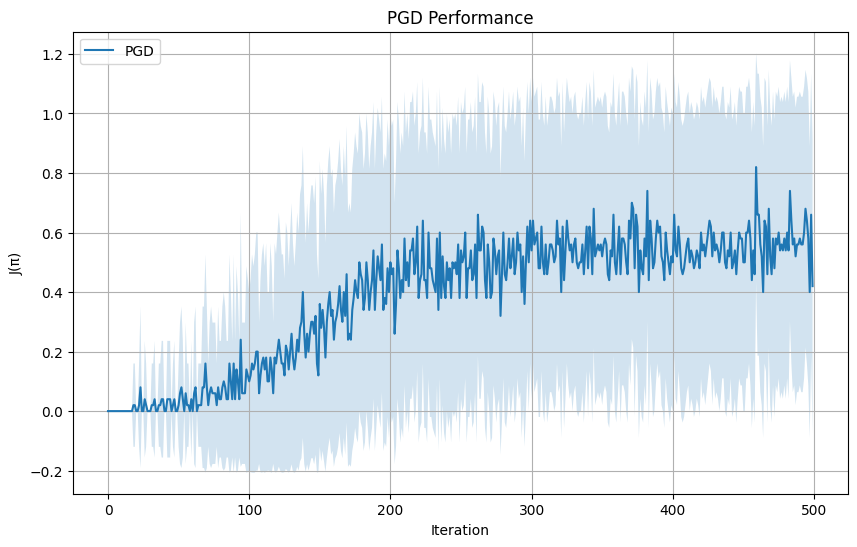

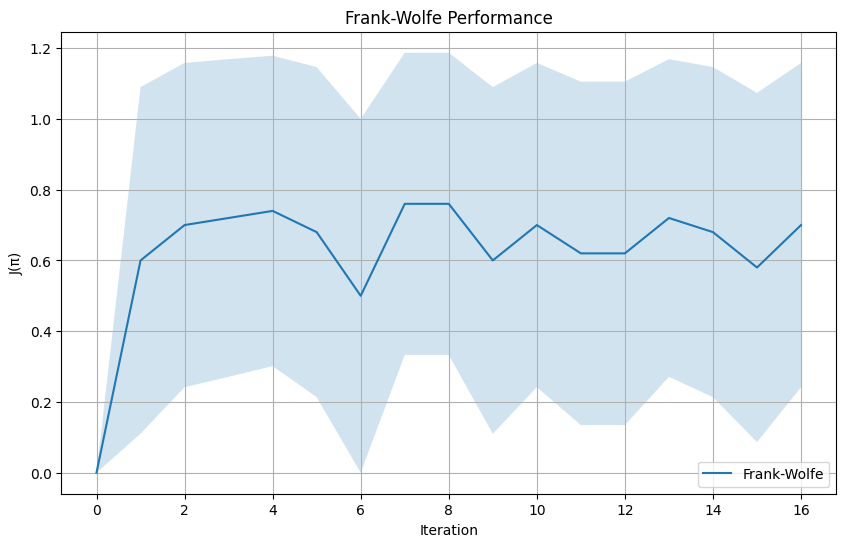


Final PGD Policy:

Most probable actions and their probabilities:
[3:0.56] [2:0.66] [2:0.52] [2:0.67] [2:1.00] [2:0.95] [2:1.00] [0:0.38] 
[3:0.80] [3:0.70] [3:1.00] [3:1.00] [3:0.77] [2:0.99] [2:1.00] [1:0.65] 
[3:0.67] [3:0.89] [0:1.00] [0:0.40] [2:1.00] [3:1.00] [2:1.00] [1:0.55] 
[3:0.97] [3:0.91] [3:0.65] [3:0.65] [0:1.00] [3:0.43] [2:1.00] [2:0.57] 
[3:0.98] [3:1.00] [0:0.53] [3:0.41] [2:1.00] [1:1.00] [3:1.00] [2:1.00] 
[0:1.00] [2:0.47] [0:0.52] [2:0.61] [3:1.00] [0:1.00] [2:0.54] [2:1.00] 
[0:1.00] [3:0.39] [1:0.48] [3:0.49] [3:0.40] [0:0.56] [0:0.39] [2:1.00] 
[0:0.74] [1:0.62] [0:0.68] [1:0.56] [1:0.58] [1:0.64] [1:1.00] [1:0.34] 

Optimal Policy (0:LEFT, 1:DOWN, 2:RIGHT, 3:UP):
[[3 2 2 2 2 2 2 0]
 [3 3 3 3 3 2 2 1]
 [3 3 0 0 2 3 2 1]
 [3 3 3 3 0 3 2 2]
 [3 3 0 3 2 1 3 2]
 [0 2 0 2 3 0 2 2]
 [0 3 1 3 3 0 0 2]
 [0 1 0 1 1 1 1 1]]

Final Frank-Wolfe Policy:

Most probable actions and their probabilities:
[3:1.00] [2:1.00] [2:1.00] [2:1.00] [2:1.00] [2:1.00] [2:1.00] [2:1.00] 

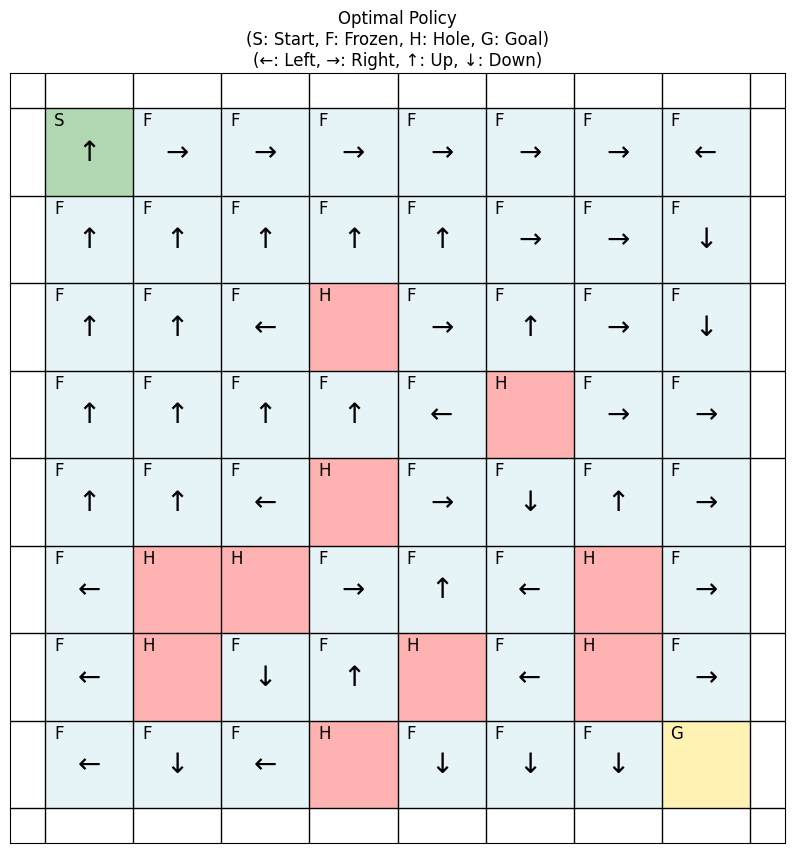

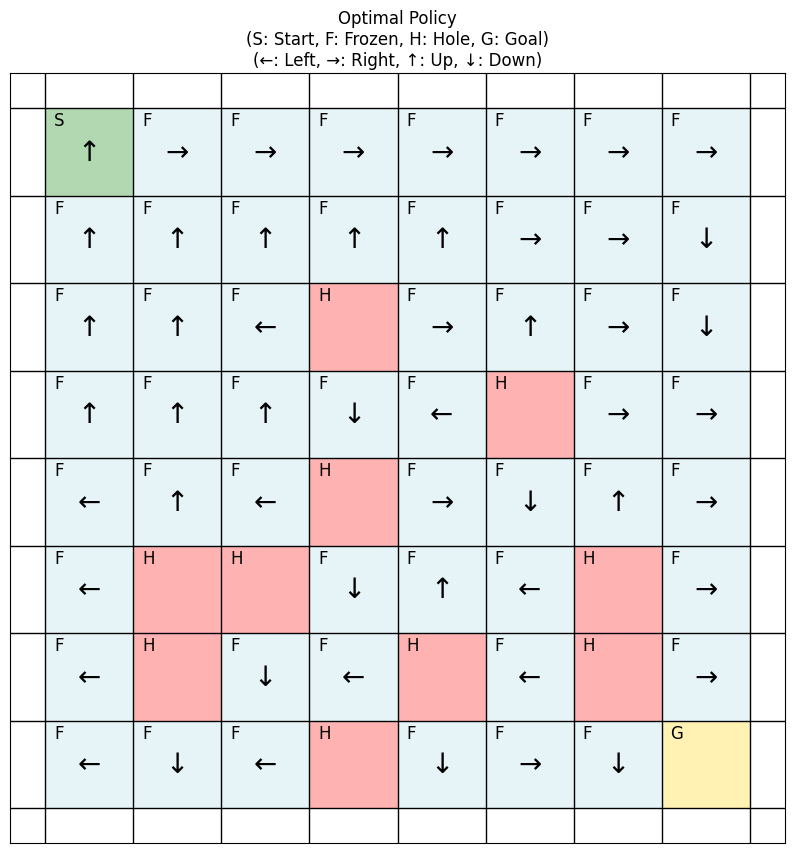

In [21]:

 
    
# Create environment
env = gym.make('FrozenLake-v1', map_name="8x8", is_slippery=True)

# Run both algorithms
print("Running Projected Gradient Descent...")
pgd_policy, pgd_history = policy_gradient_descent(env)

print("\nRunning Frank-Wolfe...")
fw_policy, fw_history = frank_wolfe(env)

# Plot performance comparison
# Plot PGD history
plot_performance(pgd_history, 'PGD')

# Plot Frank-Wolfe history
plot_performance(fw_history, 'Frank-Wolfe')

# Print final greedy policies
print("\nFinal PGD Policy:")
pgd_policy_final = get_greedy_policy(pgd_policy)

print("\nFinal Frank-Wolfe Policy:")
fw_policy_final = get_greedy_policy(fw_policy)

# Visualize the policy
plot_policy_grid(pgd_policy_final, env.unwrapped.desc)

plot_policy_grid(fw_policy_final, env.unwrapped.desc)



env.close()

# Policy Gradient and Policy Mirror Descent


 

## Policy Parameterization
The policy is parameterized using softmax distribution:
- Let $\theta \in \mathbb{R}^{S \times A}$ be the parameter matrix
- For each state $s$, policy is defined as:
$\pi_\theta(a|s) = \frac{\exp(\theta_{s,a})}{\sum_{a'} \exp(\theta_{s,a'})}$

## Algorithms

### (a) Policy Gradient with Softmax Parameterization

  

## Policy and Log-Policy
For state s, action a:
$\pi_\theta(a|s) = \frac{\exp(\theta_{s,a})}{\sum_{a'} \exp(\theta_{s,a'})}$

$\log \pi_\theta(a|s) = \theta_{s,a} - \log(\sum_{a'} \exp(\theta_{s,a'}))$

## Policy Gradient
For state s, the policy gradient is:
$\nabla_\theta J(\theta) = \mathbb{E}_{a\sim\pi_\theta(\cdot|s)}[A^{\pi_\theta}(s,a)\nabla_\theta\log\pi_\theta(a|s)]$

where $\nabla_{\theta_{s,b}} \log \pi_\theta(a|s) = \mathbb{1}[a=b] - \pi_\theta(b|s)$

Therefore, the full gradient for state s is:
$\nabla_{\theta_s} J(\theta) = \sum_a \pi_\theta(a|s)A^{\pi_\theta}(s,a)(\mathbb{1}_a - \pi_\theta(\cdot|s))$
 
 

 
### (b) Policy Mirror Descent
Updates policy directly using:
$\pi_{new}(a|s) \propto \pi_{old}(a|s)\exp(\alpha A^{\pi}(s,a))$

This is equivalent to:
1. $\theta_{new}(s,a) = \theta_{old}(s,a) + \alpha A^{\pi}(s,a)$
2. Apply softmax to get new policy


In [22]:
import numpy as np
import matplotlib.pyplot as plt

def softmax(x, axis=-1):
    """Compute softmax values over specified axis."""
    exp_x = np.exp(x - np.max(x, axis=axis, keepdims=True))
    return exp_x / np.sum(exp_x, axis=axis, keepdims=True)

def get_policy_from_theta(theta):
    """Convert parameters to policy using softmax."""
    return softmax(theta, axis=1)

def policy_gradient(env, n_iterations=1000, alpha=0.5, gamma=0.99, threshold=1e-4, pred_freq = 50):
    """
    Policy gradient with softmax parameterization.
    Implements the expected gradient over actions.
    
    Parameters:
    -----------
    env : gym-like environment
        Environment with observation_space and action_space
    n_iterations : int, optional (default=100)
        Maximum number of iterations
    alpha : float, optional (default=0.01)
        Learning rate
    gamma : float, optional (default=0.99)
        Discount factor
    threshold : float, optional (default=1e-4)
        Convergence threshold for max advantage
    
    Returns:
    --------
    final_policy : numpy.ndarray
        Optimized policy
    performance_history : list
        History of policy performance
    """
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    
    # Initialize parameters randomly
    theta = np.random.randn(n_states, n_actions) * 0.1
    performance_history = []
    advantage_history = []
    
    for t in range(n_iterations):
        # Get current policy
        policy = get_policy_from_theta(theta)
        
        # Evaluate current policy
        avg_return, std_return = evaluate_policy_return(env, policy)
        performance_history.append((avg_return, std_return))
        
        # Compute Q^π and A^π
        Q_pi, A_pi = evaluate_policy(env, policy, gamma)
        
        # Check convergence
        max_advantage = np.max(np.abs(A_pi))
        advantage_history.append(max_advantage)

        if t % pred_freq == 0:
            print(f"Iteration {t}: J(π) = {avg_return:.4f} ± {std_return:.4f}, "
                  f"Max advantage = {max_advantage:.6f}")
        
        if max_advantage < threshold:
            print(f"Converged at iteration {t}")
            break
        
        # Policy gradient update
        for s in range(n_states):
            # Compute gradient for each state-action pair
            for a in range(n_actions):
                # Score function gradient
                log_grad = np.zeros_like(policy[s])
                log_grad[a] = 1 - policy[s, a]
                
                # Update weighted by policy probability and advantage
                # theta[s] += alpha * policy[s, a] * A_pi[s, a] * log_grad
                theta[s] += alpha * A_pi[s, a] * log_grad
    
    final_policy = get_policy_from_theta(theta)
    return final_policy, performance_history
    

def policy_mirror_descent(env, n_iterations=1000, alpha=0.5, gamma=0.99, threshold=1e-4, pred_freq = 50):
    """
    Policy mirror descent with softmax parameterization.
    """
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    
    # Initialize parameters randomly
    theta = np.random.randn(n_states, n_actions) * 0.1
    performance_history = []
    advantage_history = []
    
    for t in range(n_iterations):
        # Get current policy
        policy = get_policy_from_theta(theta)
        
        # Evaluate current policy
        avg_return, std_return = evaluate_policy_return(env, policy)
        performance_history.append((avg_return, std_return))
        
        # Compute Q^π and A^π
        Q_pi, A_pi = evaluate_policy(env, policy, gamma)
        
        # Check convergence
        max_advantage = np.max(A_pi)
        advantage_history.append(max_advantage)
        if t % pred_freq == 0:
            print(f"Iteration {t}: J(π) = {avg_return:.4f} ± {std_return:.4f}, "
                  f"Max advantage = {max_advantage:.6f}")
        
        if max_advantage < threshold:
            print(f"Converged at iteration {t}")
            break
        
        # Mirror descent update
        theta += alpha * A_pi
    
    final_policy = get_policy_from_theta(theta)
    return final_policy, performance_history

def plot_comparison(pg_perf, pg_adv, pmd_perf, pmd_adv):
    """Plot performance comparison."""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
    
    # Plot returns
    pg_returns = [p[0] for p in pg_perf]
    pg_stds = [p[1] for p in pg_perf]
    pmd_returns = [p[0] for p in pmd_perf]
    pmd_stds = [p[1] for p in pmd_perf]
    
    ax1.plot(pg_returns, 'b-', label='Policy Gradient')
    ax1.fill_between(range(len(pg_returns)),
                    np.array(pg_returns) - np.array(pg_stds),
                    np.array(pg_returns) + np.array(pg_stds),
                    color='b', alpha=0.2)
    ax1.plot(pmd_returns, 'r-', label='Mirror Descent')
    ax1.fill_between(range(len(pmd_returns)),
                    np.array(pmd_returns) - np.array(pmd_stds),
                    np.array(pmd_returns) + np.array(pmd_stds),
                    color='r', alpha=0.2)
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('J(π)')
    ax1.set_title('Policy Performance')
    ax1.grid(True)
    ax1.legend()
    
    # Plot advantages
    ax2.plot(pg_adv, 'b-', label='Policy Gradient')
    ax2.plot(pmd_adv, 'r-', label='Mirror Descent')
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Max Advantage')
    ax2.set_title('Maximum Advantage')
    ax2.set_yscale('log')
    ax2.grid(True)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()


In [ ]:

    
# Create environment
env = gym.make('FrozenLake-v1', map_name="8x8", is_slippery=True)

# Run both algorithms
print("Running Policy Gradient...")
pg_policy, pg_history = policy_gradient(env)

print("\nRunning Policy Mirror Descent...")
pmd_policy, pmd_history = policy_mirror_descent(env)


# Get and print greedy policies
print("\nFinal Policy Gradient Policy:")
pg_policy_final = get_greedy_policy(pg_policy)

print("\nFinal Mirror Descent Policy:")
pmd_policy_final = get_greedy_policy(pmd_policy)

# Visualize policies
plot_policy_grid(pg_policy_final, env.unwrapped.desc)

plot_policy_grid(pmd_policy_final, env.unwrapped.desc)

env.close()

Running Policy Gradient...
Iteration 0: J(π) = 0.0000 ± 0.0000, Max advantage = 0.209600
Iteration 50: J(π) = 0.0000 ± 0.0000, Max advantage = 0.302562
Iteration 100: J(π) = 0.0400 ± 0.1960, Max advantage = 0.330814
Iteration 150: J(π) = 0.0000 ± 0.0000, Max advantage = 0.333306

IOStream.flush timed out



Iteration 200: J(π) = 0.0600 ± 0.2375, Max advantage = 0.333333


IOStream.flush timed out


Iteration 250: J(π) = 0.0600 ± 0.2375, Max advantage = 0.333333
Iteration 300: J(π) = 0.2800 ± 0.4490, Max advantage = 0.333333
Iteration 350: J(π) = 0.2200 ± 0.4142, Max advantage = 0.333333
